In [1]:
import cv2 
import numpy as np
import time
import heapq
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy.linalg import norm
import glob, os
import warnings
warnings.filterwarnings('ignore')
os.chdir("/data/Hangyu_Folder/OCR_Project/")

In [2]:
def normalize(np_array):
    array_range = np_array.max() - np_array.min()
    
    return (np_array - np_array.min()) * 255 / array_range

In [3]:
def img_diff(image1, image2):
    image1 = normalize(image1)
    image2 = normalize(image2)
    diff = image1 - image2
    z_norm = norm(diff.ravel(), 0)
    
    return z_norm

In [4]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    return err

In [74]:
def logo_parser(img_name):
    
    orig_img = cv2.imread(img_name)
    x,y,z = orig_img.shape
    
    logo = orig_img.copy()
    text = orig_img.copy()
    
    try:
        alpha = 1.3# Contrast (1.0-3.0)
        beta = 0    # Brightness (0-100)
        hc_img = cv2.convertScaleAbs(orig_img, alpha=alpha, beta=beta)

        #Part I
        #印章部分 
        logo_hsv=cv2.cvtColor(hc_img, cv2.COLOR_BGR2HSV)
        logo_bound = cv2.inRange(logo_hsv, np.array([0,50,50]), np.array([10,255,255])) + cv2.inRange(logo_hsv, np.array([170,50,50]), np.array([180,255,255]))
        logo[np.where(logo_bound == 0)] = 255
        logo[logo < 255] = 0

        #文字部分
        text_hsv=cv2.cvtColor(text, cv2.COLOR_BGR2HSV)
        text_bound = cv2.inRange(text_hsv, np.array([0,0,0]), np.array([162,162,162]))
        text[np.where(text_bound == 0)] = 255
        text[text < 255] = 0

        #Part II
        adjusted = orig_img.reshape((x * y, z))
        kmeans = KMeans(n_clusters = 8)
        clustering = kmeans.fit(adjusted)
        labels = clustering.labels_ 

        new_img = []
        for i in range(8):
            new_img.append([])
            for j in range(len(labels)):
                if labels[j] != i:
                    new_img[i].append(np.array([255,255,255]))
                else:
                    new_img[i].append(np.array([0,0,0]))    

        logo_sum = [img_diff(np.array(i).reshape(x, y, z), logo) for i in new_img]
        logo_index = list(map(logo_sum.index, heapq.nsmallest(8, logo_sum)))
        hc_logo = new_img[logo_index[0]]
        hc_logo = np.array(hc_logo).reshape(x, y, z)

        text_sum = [img_diff(np.array(i).reshape(x, y, z), text) for i in new_img]
        text_index = list(map(text_sum.index, heapq.nsmallest(8, text_sum)))
        hc_text = new_img[text_index[0]]   
        hc_text = np.array(hc_text).reshape(x, y, z)
        hc_text1 = new_img[text_index[1]]   
        hc_text1 = np.array(hc_text1).reshape(x, y, z)

        hc_text2 = new_img[text_index[2]]   
        hc_text2 = np.array(hc_text2).reshape(x, y, z)


        #位置做计算
        logo_merged = (logo + hc_logo )/2
        for i in range(x):
            for j in range(y):
                if np.sum(logo_merged[i][j]) < 510:
                    logo_merged[i][j] = 0
                else:
                    pass
        #膨胀
        #kernel = np.ones((2,2),np.uint8)
        #logo_merged = cv2.morphologyEx(logo_merged, cv2.MORPH_OPEN, kernel)

        text_merged = (text + hc_text + hc_text1 + hc_text2)/4
        text_merged[text_merged > 255] = 255
        text_merged[text_merged < 255] = 0 

        return orig_img.astype(np.uint8), logo_merged.astype(np.uint8), text_merged.astype(np.uint8)
    
    except ValueError:
        
        logo_merged = np.zeros((100,100,3), np.uint8)
        
        return orig_img.astype(np.uint8), logo_merged.astype(np.uint8), orig_img.astype(np.uint8)

Text(0.5, 1.0, 'Text')

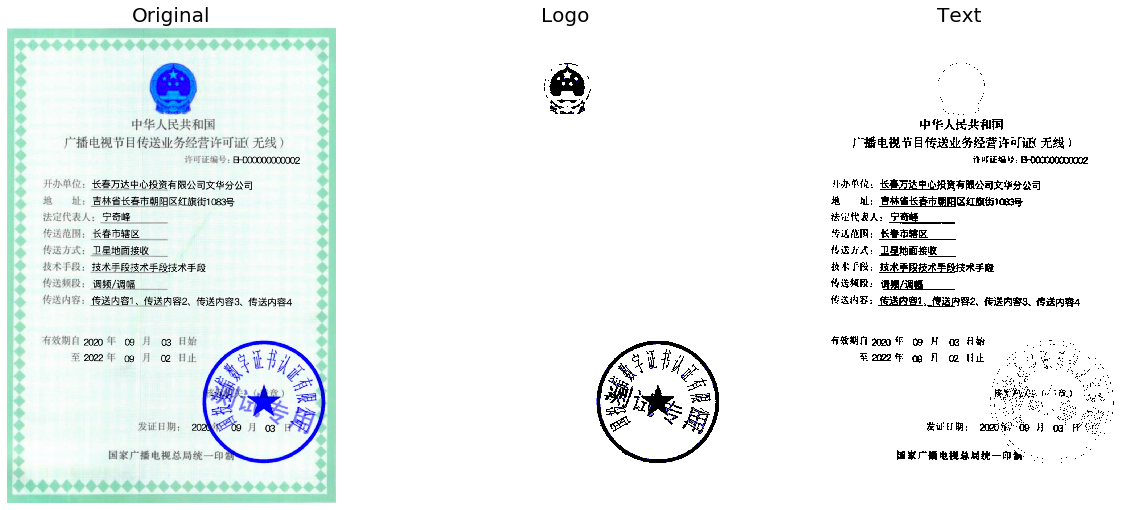

In [75]:
orig_img, logo, text = logo_parser('test_data/document/1.jpg')

fig, ax = plt.subplots(1,3,figsize=(20,20))
plt.axis("off")
ax[0].imshow(orig_img)
ax[0].axis('off')
ax[0].set_title("Original", fontsize=20)

ax[1].imshow(logo)
ax[1].axis('off')
ax[1].set_title("Logo", fontsize=20)

ax[2].imshow(text)
ax[2].axis('off')
ax[2].set_title("Text", fontsize=20)

Text(0.5, 1.0, 'Text')

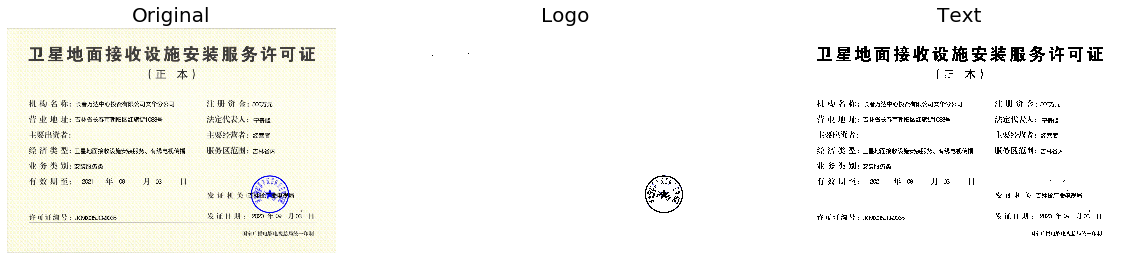

In [76]:
orig_img, logo, text = logo_parser('test_data/document/10.jpg')

fig, ax = plt.subplots(1,3,figsize=(20,20))
plt.axis("off")
ax[0].imshow(orig_img)
ax[0].axis('off')
ax[0].set_title("Original", fontsize=20)

ax[1].imshow(logo)
ax[1].axis('off')
ax[1].set_title("Logo", fontsize=20)

ax[2].imshow(text)
ax[2].axis('off')
ax[2].set_title("Text", fontsize=20)